In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import tensorflow as tf
tf.__version__

'1.13.0-rc2'

## Load the data

In [5]:
main_dir = '/home/yulia/W266-Final-Project/'

In [6]:
data_path = main_dir+'data/raw/hein-daily'

In [7]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [8]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [9]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt',p=0.3)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 8.3 seconds to create the dictionary


In [10]:
len(list(descr.keys()))/2914464

0.29461300602786655

In [11]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

In [12]:
np.unique(np.array(party), return_counts=True)

(array(['A', 'D', 'I', 'N', 'NA', 'P', 'R'], dtype='<U2'),
 array([      4,  448302,    2265,      89, 3007562,      20,  407959]))

In [13]:
party_dummy = []
for p in range(len(party)):
    if party[p] == 'D':
        party_dummy.append(1)
    elif party[p] == 'R':
        party_dummy.append(0)
    else:
        party_dummy.append(-1)
len(party_dummy)

3866201

## Data QA

In [14]:
explore_data.get_counts(party_dummy)

,Category,Count
0,-1,3009940
1,0,407959
2,1,448302


In [15]:
explore_data.random_speech(all_speeches, all_speech_ids, party_dummy, descr)

Speaker information
date 19920810
char_count 2277
word_count 366
speakerid 102115370.0
Party D
Congress 102
Chamber H
State VA
Ethnicity W
Age 46.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. BOUCHER
Full Name BOUCHER, FREDERICK
match exact
check 1

Mr. Speaker. H.R. days after enactment. 3360 Is designed to protect the Amer- The amendment in the nature of a ican public. Despite the availability substitute under consideration repand affordability of automatic sprin- resents an agreement between the kler systems and smoke detectors. the Science Committee and the CommitUnited States continues to have an un- tees on Public Works and Transporacceptably high fire death rate. Fire Is tation and Banking. Finance. and the third leading cause of accidental Urban Affairs. to which the bill was death. accounting for more than 5.500 jointly referred. deaths each year. This Is a rate that is I would like to thank Mr. ROE. chair50 percent higher than most of the in- man of the Committee on Pu

# Party Model

## Split into train, validate, test

In [16]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, party_dummy, descr)

Training split: 161472 ones and 141987 zeroes
Training speech list size: 303459
Training target list size: 303459
Validation split: 53824 ones and 47329 zeroes
Validation speech list size: 101153
Validation target list size: 101153
Test split: 53825 ones and 47329 zeroes
Test speech list size: 101154
Test target list size: 101154


In [17]:
sum(train_target), sum(val_target), sum(test_target)

(161472, 53824, 53825)

In [18]:
# number of speeches under 30 words
sum(np.array(party_dummy)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

179181

In [19]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19960522
char_count 196
word_count 40
speakerid 104109021.0
Party D
Congress 104
Chamber S
State NE
Ethnicity W
Age 75.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. EXON
Full Name EXON, J.
match exact
check 1

I am not sure the Senator from Iowa heard. I think the Chair was asking him to proceed. The next amendment up is No. 23 on my list. which is No. 4011 by Senator HARKIN. The Senator has 30 seconds.


In [20]:
del all_speeches, all_speech_ids, descr

## EDA on train data

In [21]:
explore_data.get_num_words_per_sample(train)

227.0

In [22]:
explore_data.get_num_words_per_sample(val)

227.0

In [23]:
explore_data.get_num_words_per_sample(test)

228.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  44.0  70.0  116.0  170.0  227.0  302.0  397.0  545.0  841.0  17835.0


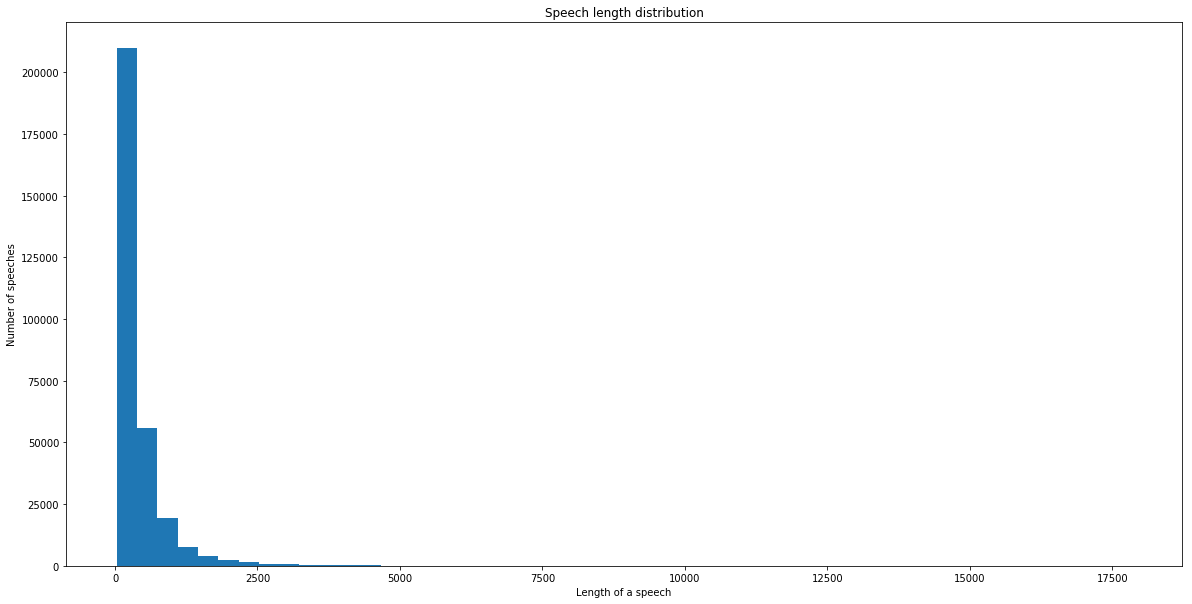

In [24]:
explore_data.plot_sample_length_distribution(train)

## CNN Models

### Pre-processing

In [25]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [26]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 266.0 seconds to tokenize the data


In [27]:
len(train), len(val), len(test)

(303459, 101153, 101154)

In [28]:
len(train_vec), len(val_vec), len(test_vec)

(303459, 101153, 101154)

In [29]:
max(map(max, train_vec)), max(map(max, val_vec)), max(map(max, test_vec))

(19999, 19999, 19999)

In [30]:
len(word_index)

689308

In [31]:
train_vec[0].shape

(750,)

In [35]:
train[1]

'Mr. President. for more than twocenturies. the U.S. Marine Corps has exemplified the highest virtues of loyalty. service. and sacrifice. From the walls of Tunn Tavern during the Revolution to the far reaches of the Pacific. from the jungles of Vietnam to the vast expanse of the Arabian desert. and from the walls of Camp Rhino and the sand of the Kandahar Airport to Guantanamo Bay. Americas Marines have shown the world the meaning of "Semper Fi." Through the long march of our history. few military organizations have been held in such high esteem as the U.S. Marine Corps. Our Marine Corps is composed of men and women of great character. They are smart. tough. dedicated. and faithful. truly the best America has to offer. For 226 years. they have stood for all that is great about this Nation: honor. courage. and commitment. Their values. sense of courage. and quiet. steadfast character remain timeless and valuable commodities for a time in which our Nation faces the greatest challenge of 

In [36]:
train_vec[1][-10:]

array([   5,    3,    2,  248,   38,   84,  508,   25, 1086,   91],
      dtype=int32)

In [37]:
for word in train[1].split()[-10:]:
    word = re.sub(r'[^\w\s]','',word)
    print(word, word_index[word])

and 5
to 3
the 2
families 248
who 38
also 84
serve 508
by 25
supporting 1086
them 91


### Saving processed files

In [38]:
token_path = main_dir+'Classification/data/tokenized/party'

In [39]:
np.save(os.path.join(token_path, 'train_vec'), train_vec)
np.save(os.path.join(token_path, 'val_vec'), val_vec)
np.save(os.path.join(token_path, 'test_vec'), test_vec)

In [40]:
pickle.dump(word_index, open(os.path.join(token_path, 'word_index.p'), 'wb'))

In [ ]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [ ]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [41]:
len(train_vec), len(val_vec), len(test_vec)

(303459, 101153, 101154)

## CNN model - Full Speech + Glove Embeddings

In [42]:
logs_base_dir = main_dir + 'Classification/logs/Party'

In [43]:
cnn_model_params = {
    'model': 'cnn',
    'word_index': word_index,
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 5,
    'pool_size': 1,
    'max_num_words': 20000,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': main_dir + 'data'
}

In [44]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 23.1 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 303459 samples, validate on 101153 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
 - 3480s - loss: 0.6694 - acc: 0.5711 - val_loss: 0.6361 - val_acc: 0.6241
Epoch 2/1000
 - 3559s - loss: 0.6193 - acc: 0.6381 - val_loss: 0.6114 - val_acc: 0.6478
Epoch 3/1000
 - 3607s - loss: 0.5913 - acc: 0.6674 - val_loss: 0.6022 - val_acc: 0.6543
Epoch 4/1000
 - 3569s - loss: 0.5705 - acc: 0.6873 - val_loss: 0.5985 - val_acc: 0.6559
Epoch 5/1000
 - 3610s - loss: 0.5508 - acc: 0.7041 - val_loss: 0.5974 - val_acc: 0.6580
Epoch 6/1000
 - 3565s - loss: 0.5293 - 

### Clean up space/save outputs

In [45]:
probs_path = main_dir+'Classification/data/probs/party/'

In [46]:
np.save(probs_path+'val_pred_probs_cnn', val_pred_probs, allow_pickle=True, fix_imports=True)

In [47]:
val_pred_probs = np.load(probs_path+'val_pred_probs_cnn.npy', allow_pickle=True, fix_imports=True)

## Model Evaluation

In [48]:
val_preds = val_pred_probs > 0.5
np.mean(val_preds.flatten()==val_target)

0.6558975018041976

In [49]:
val_preds.shape, len(val_target)

((101153, 1), 101153)

Confusion matrix, without normalization
[[28560 18769]
 [16038 37786]]
             precision    recall  f1-score   support

 Republican       0.64      0.60      0.62     47329
   Democrat       0.67      0.70      0.68     53824

avg / total       0.66      0.66      0.66    101153



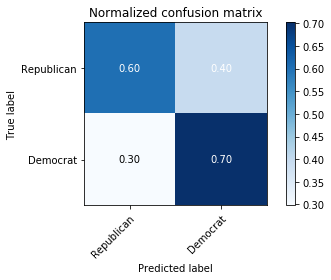

In [83]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Republican', 'Democrat']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

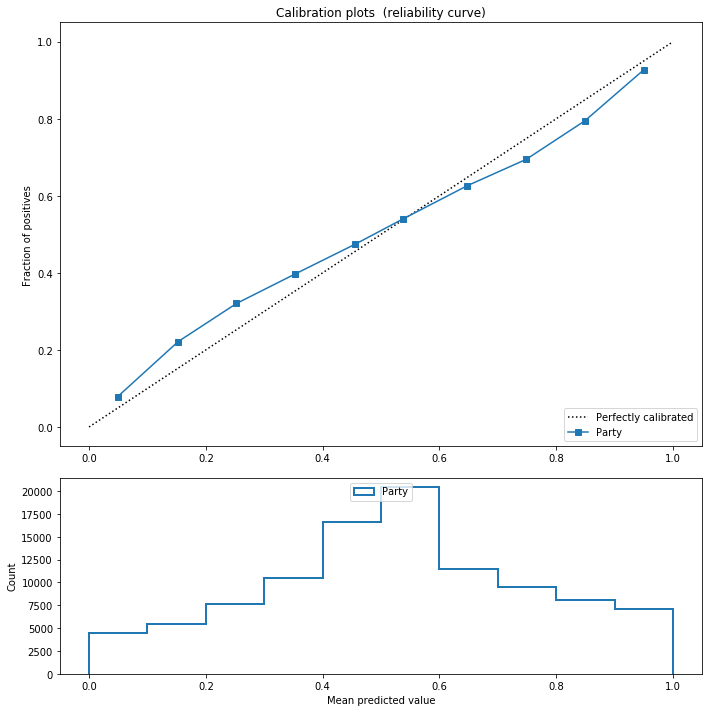

In [51]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Party')

In [52]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(106095, 16)

In [53]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.091673       0.098836  57.724436  0.529214     0.6059    381.480277


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.69,0.59,0.99,0.55,0.99,1.10
0.6,0.79,0.80,1.00,0.96,0.95,0.71
1.0,1.45,1.52,1.01,1.38,1.06,1.22


In [54]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
in the 	 1040.6
their 	 1032.9
as 	 976.4
today 	 974.7
with 	 947.4
has 	 936.1
by 	 920.5
our 	 912.4
for the 	 868.6
and the 	 853.7


bin,1,2,3
and the,25677.0,22112.0,38174.0
as,70559.0,62711.0,101922.0
by,53860.0,45068.0,77578.0
for the,24192.0,21351.0,36864.0
has,49679.0,43526.0,72915.0
in the,62363.0,53258.0,91063.0
our,55916.0,46238.0,89062.0
their,37239.0,29475.0,58634.0
today,17191.0,13744.0,25257.0
with,63221.0,55444.0,91095.0


In [55]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.92):

date             20151203
char_count           6520
word_count           1179
speakerid     1.14121e+08
Party                   D
Congress              114
Chamber                 S
State                  NV
Ethnicity               W
Age                    77
Age_lt_med              0
NonWhite                0
Female                  0
speaker          Mr. REID
Full Name     REID, HARRY
match               exact
Name: 1140066510, dtype: object

 Mr. President. I hope all Members of CongressDemocrats and Republicans. Members of the House and Senatetake a long. hard look this morning. maybe in the mirror. and ask themselves: Where do I stand? Yet again our country is faced with another sickening act of gun violence. Yesterdays shooting rampage took the lives of 14 people and wounded at least 17 more. a number of those grievously injured. That wasnt the only shooting yesterday. a gunman in Georgia killed a woman and injured three others. So where do

## CNN - chunking the data

### Prepare the data

In [56]:
chunk_len=50

In [57]:
reload(preprocess_data)
start_time = time.time()
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)
test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=chunk_len)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

Original data has 303459 speeches
It was split into 2443603 chunks
Checks on ids and target 2443603 2443603
Original target mean 0.5321048312951667
New target mean 0.5447693426469029
Original data has 101153 speeches
It was split into 819712 chunks
Checks on ids and target 819712 819712
Original target mean 0.5321048312951667
New target mean 0.5479839260618363
Original data has 101154 speeches
It was split into 819495 chunks
Checks on ids and target 819495 819495
Original target mean 0.5321094568677462
New target mean 0.5499813909785904

It took 36.1 seconds to create the dictionary


In [58]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = chunk_len

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [59]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train_chunk, val_chunk, test_chunk, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 560.6 seconds to tokenize the data


In [60]:
np.save(os.path.join(token_path, 'train_vec_chunk'), train_vec)
np.save(os.path.join(token_path, 'val_vec_chunk'), val_vec)
np.save(os.path.join(token_path, 'test_vec_chunk'), test_vec)

In [61]:
train_vec = np.load(os.path.join(token_path, 'train_vec_chunk.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec_chunk.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec_chunk.npy'))

In [62]:
train_vec.shape

(2443603, 50)

In [63]:
train_vec[0]

array([   26,    42,     2,  2926,   369, 15810,    96,     7,    23,
         257,     2,   420,     6,    60,   873,    61,  1777,     6,
           2,   115,   202,    48,    11,   694,  1799,    35,   144,
          18,   346,     8,   138,     3,   304,    37,  2723,    70,
         128,   497,     6,     2,    60,   873,  1802,    30,     2,
          35,  3605,     2,  2926,   369], dtype=int32)

In [64]:
type(train_vec)

numpy.ndarray

### Run the model

In [68]:
gc.collect()

0

In [69]:
history_chunk, train_pred_probs_chunk, val_pred_probs_chunk = train_model.train_model(((train_vec, train_target_chunk), (val_vec, val_target_chunk)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 33.3 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Train on 2443603 samples, validate on 819712 samples
Epoch 1/1000
 - 2455s - loss: 0.6580 - acc: 0.5968 - val_loss: 0.6502 - val_acc: 0.6094
Epoch 2/1000
 - 2451s - loss: 0.6409 - acc: 0.6205 - val_loss: 0.6457 - val_acc: 0.6127
Epoch 3/1000
 - 2454s - loss: 0.6328 - acc: 0.6299 - val_loss: 0.6442 - val_acc: 0.6152
Epoch 4/1000
 - 2444s - loss: 0.6260 - acc: 0.6375 - val_loss: 0.6434 - val_acc: 0.6162
Epoch 5/1000
 - 2456s - loss: 0.6189 - acc: 0.6452 - val_loss: 0.6426 - val_acc: 0.6166
Epoch 6/1000
 - 2461s - loss: 0.6123 - acc: 0.6516 - val_loss: 0.6438 - val_acc: 0.6161
Epoch 7/1000
 - 1951s - loss: 0.6059 - acc: 0.6582 - val_loss: 0.6462 - val_acc: 0.6149
Validation accuracy: 0.6148903369903564, loss: 0.6461591653009268


In [82]:
np.save(probs_path+'val_pred_probs_cnn_chunk', val_pred_probs_chunk, allow_pickle=True, fix_imports=True)

In [71]:
val_preds_chunk = val_pred_probs_chunk > 0.5
np.mean(val_preds_chunk.flatten()==val_target_chunk)

0.6148903517332917

In [72]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs_chunk.flatten(), 'preds': val_preds_chunk.flatten()})
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1000000136,0.388373,0.769508,0.553549,0,0.666667,1,1
1,1000000164,0.465058,0.465058,0.465058,1,0.000000,0,0
2,1000000280,0.447063,0.488115,0.467589,0,0.000000,0,0
3,1000000329,0.428595,0.956551,0.600979,1,0.500000,1,0
4,1000000342,0.379418,0.897738,0.606922,1,0.916667,1,1


In [73]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean), np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

(0.6750565974316135, 0.6585172955819403)

In [86]:
original_df = pd.DataFrame({'target_orig': val_target, 'ids': val_ids})
original_df = original_df.merge(pred_aggr_df, on="ids")
original_df.head()

,target_orig,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1,1020203893,0.357674,0.511737,0.434706,1,0.500000,0,0
1,1,1030062300,0.464899,0.688740,0.563689,1,0.666667,1,1
2,1,1100205980,0.441567,0.576299,0.500880,1,0.400000,1,0
3,1,990019658,0.468098,0.854251,0.676247,1,0.909091,1,1
4,1,1130043981,0.426884,0.698572,0.536981,1,0.600000,1,1


In [87]:
original_df.target_orig.sum(), original_df.target.sum()

(53824, 53824)

## Model evaluation

In [88]:
val_pred_aggr_chunk = original_df.preds_probs_mean
val_pred_probs_aggr_chunk = original_df.probs_mean
# val_aggr_target = pred_aggr_df.target
# val_aggr_ids = pred_aggr_df.ids

In [95]:
np.save(probs_path+'val_pred_probs_cnn_aggr_chunk', val_pred_probs_aggr_chunk, allow_pickle=True, fix_imports=True)

Confusion matrix, without normalization
[[29534 17795]
 [15074 38750]]
             precision    recall  f1-score   support

 Republican       0.66      0.62      0.64     47329
   Democrat       0.69      0.72      0.70     53824

avg / total       0.67      0.68      0.67    101153



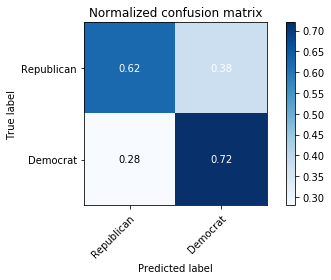

In [94]:
reload(explore_data)
# specify class names in 0 - 1 order
explore_data.plot_confusion_matrix(val_target, val_pred_aggr_chunk, classes, normalize=True)

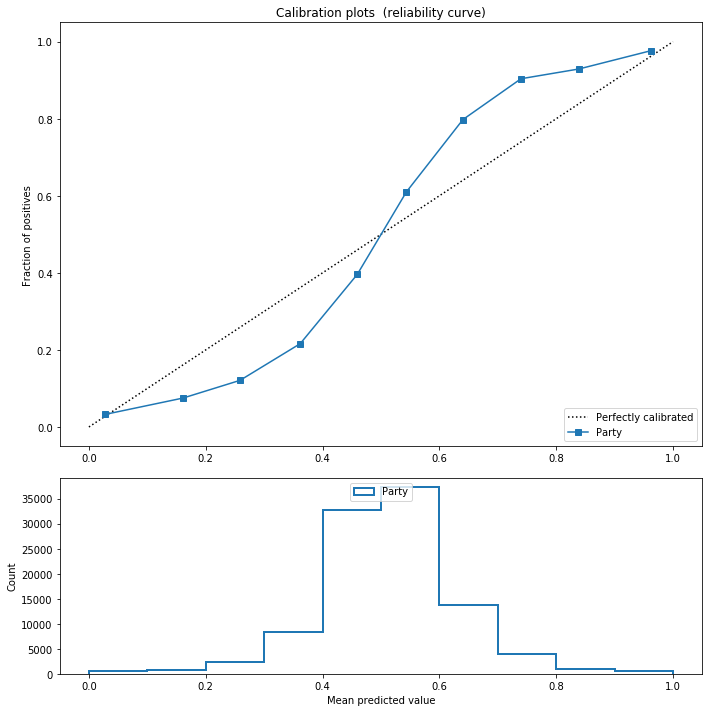

In [92]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs_aggr_chunk, 'Party')

In [78]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs_aggr_chunk, 
                                   val_aggr_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.091673       0.098836  57.724436  0.529214     0.6059    381.480277


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.63,0.47,0.99,0.34,1.02,0.76
0.6,0.84,0.82,1.00,0.96,0.96,1.05
1.0,1.82,1.97,1.02,1.55,1.11,0.97


In [79]:
reload(explore_data)
explore_data.compare_ngrams(val_chunk, val_pred_probs_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
spending 	 4815.4
tax 	 2688.5
republican 	 2680.5
health 	 2519.8
taxes 	 2445.2
community 	 2142.4
that 	 2109.7
workers 	 2098.0
government 	 2035.9
the republican 	 2004.5


bin,1,2,3
community,3463.0,10374.0,12518.0
government,14193.0,21640.0,8766.0
health,5415.0,14636.0,18197.0
republican,2205.0,3181.0,7479.0
spending,9376.0,6030.0,2345.0
tax,13626.0,12212.0,10572.0
taxes,5239.0,3411.0,1574.0
that,146057.0,386169.0,167669.0
the republican,662.0,1142.0,3750.0
workers,965.0,3812.0,6809.0


In [80]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs_aggr_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
signature the 	 19.0
impassioned speech 	 18.6
vietnam think 	 18.6
paid her 	 18.3
increasing problem 	 17.1
million prescriptions 	 16.8
empirical data 	 16.4
approxi 	 15.6
properly represented 	 15.4
lowest percent 	 15.4


bin,1,2,3
approxi,7.0,1.0,3.0
empirical data,9.0,5.0,0.0
impassioned speech,5.0,0.0,0.0
increasing problem,9.0,6.0,0.0
lowest percent,6.0,1.0,1.0
million prescriptions,6.0,0.0,0.0
paid her,6.0,1.0,0.0
properly represented,6.0,1.0,1.0
signature the,12.0,8.0,1.0
vietnam think,5.0,0.0,0.0


In [81]:
len(val_target), len(val), len(val_ids), val_pred_probs_aggr_chunk.shape

(101153, 101153, 101153, (101153,))